In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
#instalar aws library
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [ ]:
import json, os

# Import credentials from an external configuration file
credentials_path = '/content/drive/MyDrive/Fede_salud_analytics/Copy of credentials.json'

with open(credentials_path, 'r') as file:
    credentials = json.load(file)

# Configurar AWS CLI
!aws configure set aws_access_key_id {credentials['AWS_ACCESS_KEY_ID']}
!aws configure set aws_secret_access_key {credentials['AWS_SECRET_ACCESS_KEY']}
!aws configure set region {credentials['AWS_REGION']}

# Define the bucket name
BUCKET = 'proyecto-1'

# Define the directories as constants
TEST = 'archives/'

LOCAL_WORK_DIR = f'/content/drive/MyDrive/Fede_salud_analytics/{BUCKET}/'

if not os.path.exists(LOCAL_WORK_DIR):
  os.makedirs(LOCAL_WORK_DIR)

In [ ]:


# select repository
repo = TEST

local_repo = f'{LOCAL_WORK_DIR}{repo}'
if not os.path.exists(local_repo):
  os.makedirs(local_repo)

In [ ]:
# list files in repo
!aws s3 ls s3://{BUCKET}/{repo}

2024-09-24 23:49:53  509161967 2006.csv
2024-09-24 23:49:53  739501753 2007.csv
2024-09-24 23:49:53  575756609 2008.csv
2024-09-24 23:49:53  622989938 2009.csv
2024-09-24 23:49:53  203699715 2010.csv
2024-09-24 23:49:53  748510526 2011.csv
2024-09-24 23:49:53  517034993 2012.csv
2024-09-24 23:49:53  646094200 2013.csv
2024-09-24 23:49:53  426064201 2014.csv
2024-09-24 23:49:53  541280489 2015.csv
2024-09-24 23:49:53  445632133 2016.csv
2024-09-24 23:49:53  542045663 2017.csv
2024-09-24 23:49:53  402905232 2018.csv
2024-09-24 23:49:54  643302314 2019.csv
2024-09-24 23:49:53  498248615 2020.csv
2024-09-24 23:49:53  593676838 2021.csv


### Obtención y Exploración de Datos:

In [ ]:
# sync or get remote repository
!aws s3 sync s3://{BUCKET}/{repo} {local_repo}


Instalar apache spark para usar con colab

In [ ]:
# Instalar e iniciar PySpark en Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"
findspark.init()

# Importar SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA_BRFSS").getOrCreate()

In [ ]:
from pyspark.sql import functions as F

Cargar el Dataset en spark

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Fede_salud_analytics/proyecto-1/archives/2006.csv', header=True, inferSchema=True)

### Creamos una muestra

In [ ]:
df_sampled = df.sample(fraction=0.1, seed=123)


### Modificamos Weight y Height


- 'WEIGHT2' Filtrar por 4 digitos que comience con 9 = Kg.
Eliminar el 9 => 23 a 352 kg
Reference: 9023-9352: Weight (kilograms) Notes: The initial ´9´ indicates this was a metric value.
Histograma
- 'HEIGHT3': Altura.
200 -711 Height (ft/inches) Notes: 0 _ / _ _ = feet / inches => filtro por 3 digitos
Conversion a cm.
si comienza en 9, es cm.
Eliminar el 9
Histograma

In [ ]:
df_sampled = df_sampled.withColumn('WEIGHT2', F.col('WEIGHT2').cast('float')) \
                       .withColumn('HEIGHT3', F.col('HEIGHT3').cast('float')) \
                       .withColumn('_BMI4', F.col('_BMI4').cast('float'))

In [ ]:
#Modificamos la columna Weight para poder usarla

from pyspark.sql import functions as F

# Definir la función para convertir y redondear los pesos
def convert_weight(weight):
    if weight == 7777 or weight == 9999:  # "Don't know/Not sure" o "Refused"
        return None
    elif weight >= 9023 and weight <= 9352:  # Peso en kilogramos
        return round(weight - 9000, 2)  # Remover el '9' inicial y redondear
    elif weight > 0 and weight < 7777:  # Peso en libras
        return round(weight * 0.453592, 2)  # Convertir libras a kilogramos y redondear
    else:
        return None  # Para los valores no aplicables o vacíos

# Crear la columna con los valores convertidos y redondeados
df_sampled = df_sampled.withColumn('weight_kg', F.udf(convert_weight)(df_sampled['WEIGHT2']))


In [ ]:
# Modificamos la columna Height para poder usarla

# Definir la función para convertir y redondear las alturas
def convert_height(height):
    if height == 7777 or height == 9999:  # "Don't know/Not sure" o "Refused"
        return None
    elif height >= 9061 and height <= 9998:  # Altura en metros/centímetros
        return round((height - 9000) / 100, 2)  # Convertir centímetros a metros y redondear
    elif height > 0 and height < 7777:  # Altura en pies/pulgadas
        feet = height // 100  # Extraer los pies
        inches = height % 100  # Extraer las pulgadas
        total_inches = (feet * 12) + inches  # Convertir todo a pulgadas
        return round(total_inches * 0.0254, 2)  # Convertir pulgadas a metros y redondear
    else:
        return None  # Para los valores no aplicables o vacíos

# Crear la columna con los valores convertidos y redondeados
df_sampled = df_sampled.withColumn('height_m', F.udf(convert_height)(df_sampled['HEIGHT3']))


In [ ]:
# Definir la función para convertir el BMI
def convert_bmi(bmi):
    if bmi == -9999:  # Caso donde el valor es válido
        return None
    else:
        return round(bmi / 100, 2)  # El valor tiene 2 decimales implícitos, se redondea a 2 decimales

# Crear la columna con los valores de BMI convertidos
df_sampled = df_sampled.withColumn('bmi_converted', F.udf(convert_bmi)(df_sampled['_BMI4']))

In [ ]:
# Lista de posibles valores que representan NaN en forma de string
nan_values = ['NaN', 'nan', 'NULL', 'null', '']

# Reemplazar los valores de la lista con Null
df_sampled = df_sampled.replace(nan_values, None)

Pasamos de Df de pyspart a df de pandas


In [ ]:
# Para no ver el output
%%capture
# Convert to Pandas DataFrame
df_pandas = df_sampled.toPandas()

Now we have to create a df with the columns that we decide are relevante for the task at hand

In [ ]:
columnas_comunes = ['AGE', 'SEX', 'height_m', 'weight_kg', 'bmi_converted', 'BLDSUGAR',
                    'CHKHEMO3', '_TOTINDA', '_SMOKER3', 'SMOKDAY2', 'EDUCA', 'MARITAL']
df_pandas_clean = df_pandas[columnas_comunes]
df_pandas_clean.head()


,AGE,SEX,height_m,weight_kg,bmi_converted,BLDSUGAR,CHKHEMO3,_TOTINDA,_SMOKER3,SMOKDAY2,EDUCA,MARITAL
0,59.0,1.0,1.85,58.97,17.19,None,None,1.0,2.0,2.0,4.0,1.0
1,51.0,1.0,1.88,88.45,25.09,None,None,1.0,4.0,None,6.0,1.0
2,59.0,2.0,1.68,91.63,32.67,201.0,6.0,1.0,2.0,2.0,3.0,2.0
3,80.0,1.0,1.78,102.06,32.35,None,None,1.0,3.0,3.0,5.0,1.0
4,50.0,1.0,1.88,117.93,33.45,301.0,1.0,1.0,1.0,1.0,6.0,1.0


Ahora dejamos solo las columnas donde 'BLDSUGAR' no es NULL

In [ ]:
# Eliminar filas donde 'BLDSUGAR' es NaN o null
df_pandas_clean = df_pandas_clean.dropna(subset=['BLDSUGAR'])

# Mostrar las primeras filas para verificar
df_pandas_clean.head()

,AGE,SEX,height_m,weight_kg,bmi_converted,BLDSUGAR,CHKHEMO3,_TOTINDA,_SMOKER3,SMOKDAY2,EDUCA,MARITAL
2,59.0,2.0,1.68,91.63,32.67,201.0,6.0,1.0,2.0,2.0,3.0,2.0
4,50.0,1.0,1.88,117.93,33.45,301.0,1.0,1.0,1.0,1.0,6.0,1.0
11,56.0,1.0,1.96,121.11,31.73,204.0,4.0,1.0,3.0,3.0,6.0,1.0
28,51.0,2.0,1.57,109.32,44.17,103.0,4.0,1.0,4.0,None,5.0,1.0
29,55.0,2.0,1.6,81.65,31.95,404.0,4.0,2.0,4.0,None,4.0,1.0


A patir de aca vamos a modificar las columnas para dejar el DF final

In [ ]:
# Transformar la columna _SMOKER3 a una columna binaria
df_pandas_clean['_SMOKER3_binary'] = df_pandas_clean['_SMOKER3'].apply(lambda x: 1 if x in [1, 2] else 0)

# Mostrar las primeras filas para verificar
df_pandas_clean[['_SMOKER3', '_SMOKER3_binary']].head()

,_SMOKER3,_SMOKER3_binary
2,2.0,1
4,1.0,1
11,3.0,0
28,4.0,0
29,4.0,0


In [ ]:
df_pandas_clean['EDUCA'] = df_pandas_clean['EDUCA'].astype(float)


education_categories = {
    1.0: 'No School',
    2.0: 'Elementary',
    3.0: 'Some High School',
    4.0: 'High School Graduate',
    5.0: 'Some College',
    6.0: 'College Graduate',
    9.0: 'Refused'
}



df_pandas_clean['EDUCA_CATEGORY'] = df_pandas_clean['EDUCA'].map(education_categories)

# Mostrar las primeras filas para verificar
df_pandas_clean.head()

,AGE,SEX,height_m,weight_kg,bmi_converted,BLDSUGAR,CHKHEMO3,_TOTINDA,_SMOKER3,SMOKDAY2,EDUCA,MARITAL,_SMOKER3_binary,EDUCA_CATEGORY
2,59.0,2.0,1.68,91.63,32.67,201.0,6.0,1.0,2.0,2.0,3.0,2.0,1,Some High School
4,50.0,1.0,1.88,117.93,33.45,301.0,1.0,1.0,1.0,1.0,6.0,1.0,1,College Graduate
11,56.0,1.0,1.96,121.11,31.73,204.0,4.0,1.0,3.0,3.0,6.0,1.0,0,College Graduate
28,51.0,2.0,1.57,109.32,44.17,103.0,4.0,1.0,4.0,None,5.0,1.0,0,Some College
29,55.0,2.0,1.6,81.65,31.95,404.0,4.0,2.0,4.0,None,4.0,1.0,0,High School Graduate


In [ ]:
df_pandas_clean['MARITAL'] = df_pandas_clean['MARITAL'].astype(float)

marital_categories = {
    1.0: 'Married',
    2.0: 'Divorced',
    3.0: 'Widowed',
    4.0: 'Separated',
    5.0: 'Never Married',
    6.0: 'Living with Partner'
    }


df_pandas_clean['MARITAL_CATEGORY'] = df_pandas_clean['MARITAL'].map(marital_categories)

df_pandas_clean.head()


,AGE,SEX,height_m,weight_kg,bmi_converted,BLDSUGAR,CHKHEMO3,_TOTINDA,_SMOKER3,SMOKDAY2,EDUCA,MARITAL,_SMOKER3_binary,EDUCA_CATEGORY,MARITAL_CATEGORY
2,59.0,2.0,1.68,91.63,32.67,201.0,6.0,1.0,2.0,2.0,3.0,2.0,1,Some High School,Divorced
4,50.0,1.0,1.88,117.93,33.45,301.0,1.0,1.0,1.0,1.0,6.0,1.0,1,College Graduate,Married
11,56.0,1.0,1.96,121.11,31.73,204.0,4.0,1.0,3.0,3.0,6.0,1.0,0,College Graduate,Married
28,51.0,2.0,1.57,109.32,44.17,103.0,4.0,1.0,4.0,None,5.0,1.0,0,Some College,Married
29,55.0,2.0,1.6,81.65,31.95,404.0,4.0,2.0,4.0,None,4.0,1.0,0,High School Graduate,Married


In [ ]:
df_pandas_clean['CHKHEMO3'] = df_pandas_clean['CHKHEMO3'].astype(float)

# Definir función de categorización
def categorize_a1c_check(value):
    if 1 <= value <= 4:
        return "Low frequency"
    elif 5 <= value <= 10:
        return "Moderate frequency"
    elif 11 <= value <= 76:
        return "High frequency"
    elif value == 88:
        return "None"
    elif value == 98:
        return "Never heard of A1C"
    elif value == 77:
        return "Don’t know/Not sure"
    elif value == 99:
        return "Refused"
    else:
        return np.nan  # Para valores BLANK u otros no especificados

# Aplicar la función para crear la columna categorizada
df_pandas_clean['A1C_CHECK'] = df_pandas_clean['CHKHEMO3'].apply(categorize_a1c_check)

# Verificar el resultado
df_pandas_clean[['CHKHEMO3', 'A1C_CHECK']].head()

,CHKHEMO3,A1C_CHECK
2,6.0,Moderate frequency
4,1.0,Low frequency
11,4.0,Low frequency
28,4.0,Low frequency
29,4.0,Low frequency


In [ ]:
print(df_pandas_clean.dtypes)

AGE                 float64
SEX                 float64
height_m             object
weight_kg            object
bmi_converted        object
BLDSUGAR             object
CHKHEMO3            float64
_TOTINDA            float64
_SMOKER3            float64
SMOKDAY2             object
EDUCA               float64
MARITAL             float64
_SMOKER3_binary       int64
EDUCA_CATEGORY       object
MARITAL_CATEGORY     object
A1C_CHECK            object
dtype: object


In [ ]:
df_pandas_clean['BLDSUGAR'] = df_pandas_clean['BLDSUGAR'].astype(float)

def categorize_BLDSUGAR_check(value):
    if 101 <= value <= 199:  # Corregido
        new_value = value - 100
        return f"{new_value} times a day"
    elif 201 <= value <= 299:  # Corregido
        new_value = value - 200
        return f"{new_value} times a week"
    elif 301 <= value <= 399:  # Corregido
        new_value = value - 300
        return f"{new_value} times a month"
    elif 401 <= value <= 499:  # Corregido
        new_value = value - 400
        return f"{new_value} times a year"
    elif value == 777:
        return "Don’t know/Not sure"
    elif value == 888:
        return "Never"
    elif value == 999:
        return "Refused"
    else:
        return np.nan  # Para valores BLANK u otros no especificados

# Aplicar la función para crear la columna categorizada
df_pandas_clean['blood_sugar_check'] = df_pandas_clean['BLDSUGAR'].apply(categorize_BLDSUGAR_check)

# Verificar el resultado
print(df_pandas_clean[['BLDSUGAR', 'blood_sugar_check']].head())

    BLDSUGAR  blood_sugar_check
2      201.0   1.0 times a week
4      301.0  1.0 times a month
11     204.0   4.0 times a week
28     103.0    3.0 times a day
29     404.0   4.0 times a year


In [ ]:
df_pandas_clean['SMOKDAY2'] = df_pandas_clean['SMOKDAY2'].astype(float)


def categorize_activity(value):
    if value == 1:
        return "Every day"
    elif value == 2:
        return "Some days"
    elif value == 3:
        return "Not at all"
    elif value == 7:
        return "Don’t know/Not sure"
    elif value == 9:
        return "Refused"
    elif pd.isna(value) or value == "":  # Para BLANK o valores faltantes
        return "Not asked or Missing"
    else:
        return np.nan  # Para valores no especificados

# Aplicar la función para crear la columna categorizada en el DataFrame
df_pandas_clean['SMOKE_FREQ'] = df_pandas_clean['SMOKDAY2'].apply(categorize_activity)

# Verificar el resultado
print(df_pandas_clean[['SMOKDAY2', 'SMOKE_FREQ']].head())


    SMOKDAY2            SMOKE_FREQ
2        2.0             Some days
4        1.0             Every day
11       3.0            Not at all
28       NaN  Not asked or Missing
29       NaN  Not asked or Missing


Ahora que tenemos que eliminar las columnas que ya fueron modificadas a columnas categoricas

In [ ]:
def categorize_activity(value):
    if value == 1.0:
        return "Physically Active"
    elif value == 2.0:
        return "Physically Inactive"
    elif value == 9.0:
        return "Don’t know/Refused/Missing"

df_pandas_clean['PHYSICAL_ACTIVITY'] = df_pandas_clean._TOTINDA.apply(categorize_activity)

print(df_pandas_clean[['_TOTINDA', 'PHYSICAL_ACTIVITY']].head())

    _TOTINDA    PHYSICAL_ACTIVITY
2        1.0    Physically Active
4        1.0    Physically Active
11       1.0    Physically Active
28       1.0    Physically Active
29       2.0  Physically Inactive


In [ ]:
columns_to_delete = ['BLDSUGAR', 'CHKHEMO3', '_SMOKER3', 'SMOKDAY2', 'EDUCA', 'MARITAL', '_TOTINDA']
df_pandas_clean = df_pandas_clean.drop(columns=columns_to_delete)


In [ ]:
df_pandas_clean.head()

,AGE,SEX,height_m,weight_kg,bmi_converted,_SMOKER3_binary,EDUCA_CATEGORY,MARITAL_CATEGORY,A1C_CHECK,blood_sugar_check,SMOKE_FREQ,PHYSICAL_ACTIVITY
2,59.0,2.0,1.68,91.63,32.67,1,Some High School,Divorced,Moderate frequency,1.0 times a week,Some days,Physically Active
4,50.0,1.0,1.88,117.93,33.45,1,College Graduate,Married,Low frequency,1.0 times a month,Every day,Physically Active
11,56.0,1.0,1.96,121.11,31.73,0,College Graduate,Married,Low frequency,4.0 times a week,Not at all,Physically Active
28,51.0,2.0,1.57,109.32,44.17,0,Some College,Married,Low frequency,3.0 times a day,Not asked or Missing,Physically Active
29,55.0,2.0,1.6,81.65,31.95,0,High School Graduate,Married,Low frequency,4.0 times a year,Not asked or Missing,Physically Inactive


<Figure size 1200x600 with 0 Axes>

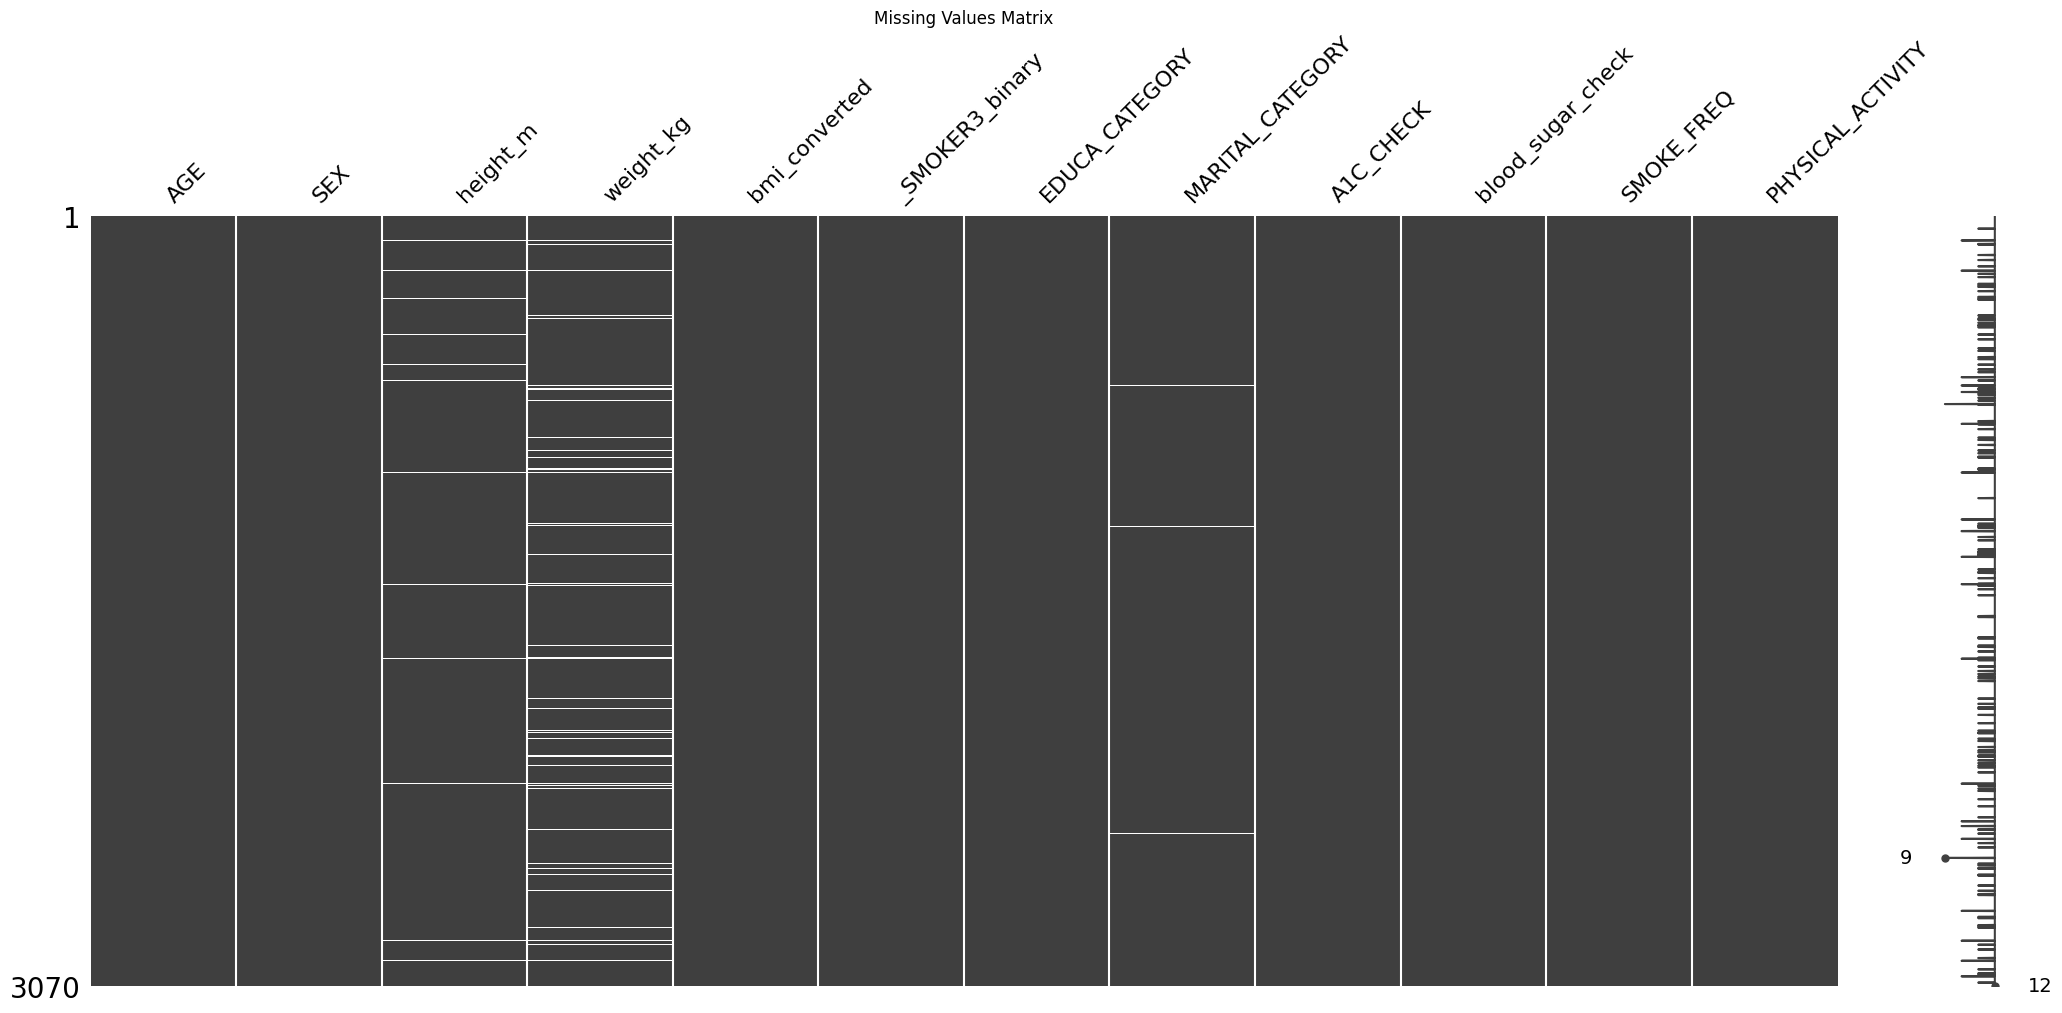

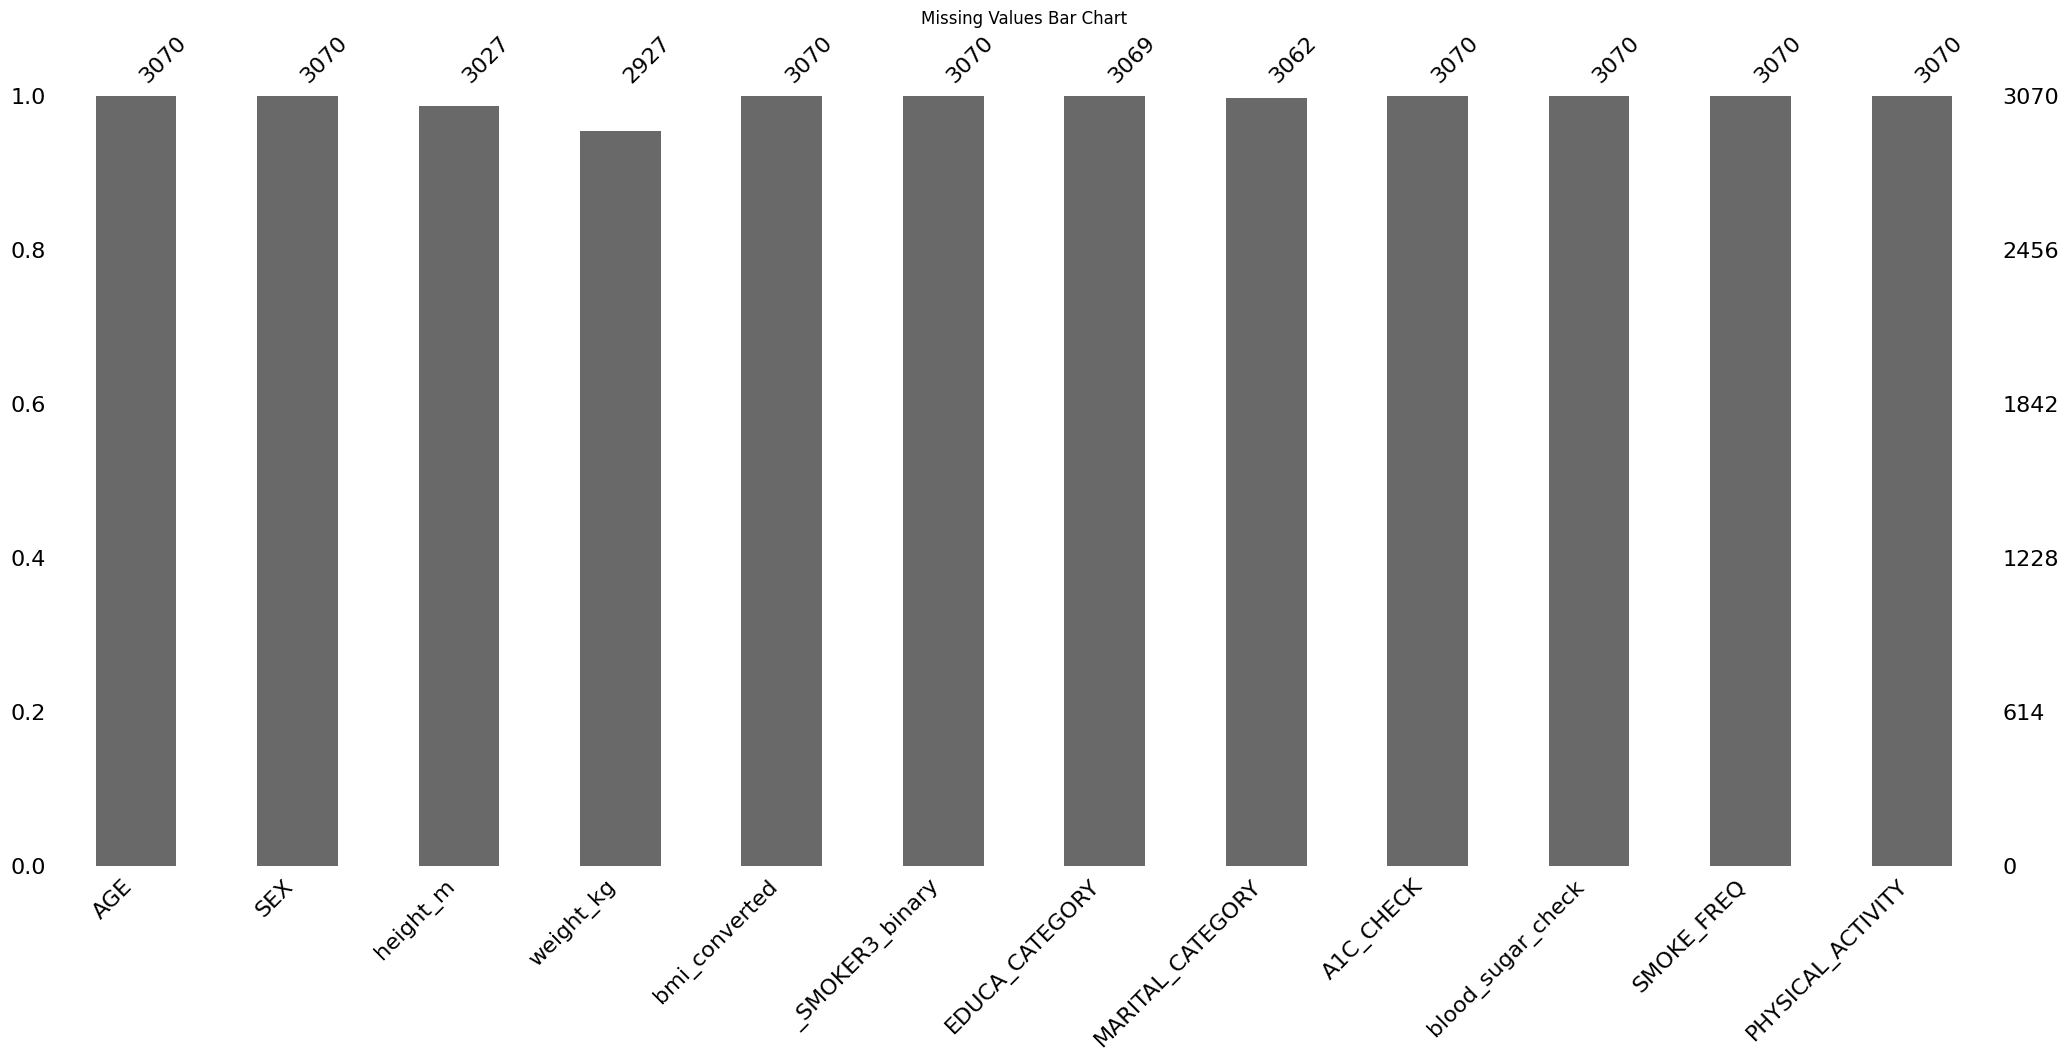

In [ ]:
# veamos cuantos valores faltantes tiene
import missingno as msno
import matplotlib.pyplot as plt

# Visualizar el patrón de valores nulos
plt.figure(figsize=(12, 6))
msno.matrix(df_pandas_clean)
plt.title('Missing Values Matrix')
plt.show()

# Visualizar el resumen de valores nulos
plt.figure(figsize=(12, 6))
msno.bar(df_pandas_clean)
plt.title('Missing Values Bar Chart')
plt.show()

### Valores Null restantes
Aun tenemos valores null en las columnas de Weight y Height los completo con los valores promedio para poder realizar el PCA

In [ ]:
# Convert columns to numeric, forcing any non-numeric values to NaN
df_pandas_clean['height_m'] = pd.to_numeric(df_pandas_clean['height_m'], errors='coerce')
df_pandas_clean['weight_kg'] = pd.to_numeric(df_pandas_clean['weight_kg'], errors='coerce')

# Fill NaN values with the mean of each column
df_pandas_clean['height_m'].fillna(df_pandas_clean['height_m'].mean(), inplace=True)
df_pandas_clean['weight_kg'].fillna(df_pandas_clean['weight_kg'].mean(), inplace=True)


<ipython-input-31-c04f2bbdbe88>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pandas_clean['height_m'].fillna(df_pandas_clean['height_m'].mean(), inplace=True)
<ipython-input-31-c04f2bbdbe88>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

### Pre-procesamiento para PCA

Normalización/Estandarización de Datos: PCA es sensible a la escala de los datos, por lo que necesitamos normalizar las variables continuas (e.g., AGE, height_m, weight_kg, bmi_converted) para que cada variable tenga una media de 0 y una desviación estándar de 1.

**Sugerencia visualizar el PCA con y sin normalizacion para ver el impacto que tiene en la distribucion de los datos**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


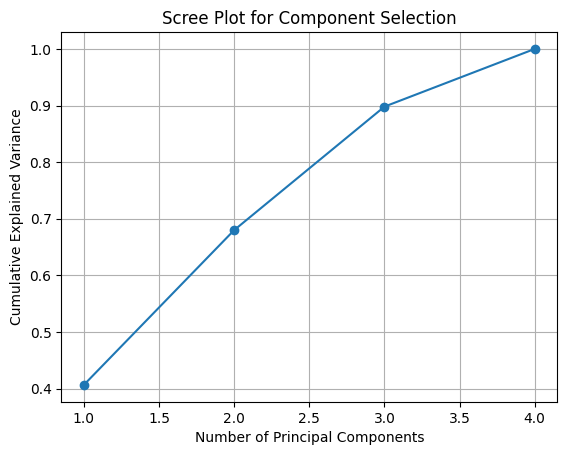

Loadings of each component on the original variables:
                    PC1       PC2       PC3       PC4
AGE           -0.404465 -0.194894  0.888342  0.096297
height_m       0.478909 -0.666615  0.132042 -0.555730
weight_kg      0.682306 -0.043581  0.225872  0.693932
bmi_converted  0.376182  0.718152  0.377353 -0.447605
Principal components:
        PC1       PC2       PC3       PC4
0  0.092873 -0.026620 -0.223942  0.153907
1  2.082089 -1.149703 -0.270140 -0.117683
2  2.321229 -1.805842  0.208803 -0.339556
3  0.649942  1.213906 -0.434793  0.922938
4 -0.471941  0.511742 -0.698684  0.237400


In [ ]:
# Creamos un Df de valores numericos
data = df_pandas_clean[['AGE', 'height_m', 'weight_kg', 'bmi_converted']]

# Paso 1 normalizamos las variables ]
scaler = StandardScaler()
data_scaleed = scaler.fit_transform(data)


#Paso 2: Aplicacion de PCA
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(data_scaleed)


# Convertimos los componentes principales en un DataFrame para facilidad de interpretación
pca_df = pd.DataFrame(
    principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

# Paso 3: Visualización de la varianza explicada acumulada (Scree Plot)
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for Component Selection')
plt.grid()
plt.show()

# Paso 4: Interpretación de los Componentes Principales
# Examina la carga de cada componente
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=data.columns)
print("Loadings of each component on the original variables:")
print(loadings)

# Mostrar los primeros componentes principales
print("Principal components:")
print(pca_df.head())

In [ ]:
file_path = '/content/drive/MyDrive/Fede - Salud Analytics/Proyectos/producto_final/df_pandas_clean.csv'
df_pandas_clean.to_csv(file_path, index=False)